# More advanced fitting formulation

    t0 = 2 * d_spacing
    term0 = a2 * (t - a6)
    term1 = ((a5 - a2) / 2) * (t - a6)
    term3 = erfc(-((t-t0)/(sigma * math.sqrt(2))))
    term4 = np.exp(-((t-t0)/alpha) + ((sigma*sigma)/(2*alpha*alpha)))
    term5 = erfc(-((t-t0)/(sigma * math.sqrt(2))) + sigma/alpha)

    y = a1 + term0 + term1 * ( term3 - term4 * term5)

    linear fit of the lines before and after the bragg edge:
    a2=slope of the first line
    a5=slope of the second line
    a6 can be estimated as x-(2*I/(a5-a2), where x= rough position of the edge, I=edge intensity
    a1 can be estimated by intercept of the first or second line from linear fit or intercept+a2*a6 (this is now not so crystal clear)


In [30]:
import numpy as np
from numpy import pi, r_, math, random
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.special import erfc
from lmfit import Model
from numpy import loadtxt
%matplotlib inline
# %matplotlib notebook

In [2]:
def term0(t,a2,a6):
    return  a2 * (t - a6)

In [3]:
def term1(t,a2,a5,a6):
    return ((a5 - a2) / 2) * (t - a6)

In [4]:
def term3(t,t0,sigma):
    return erfc(-((t-t0)/(sigma * math.sqrt(2))))

In [5]:
def term4(t,t0,alpha,sigma):
    return np.exp(-((t-t0)/alpha) + ((sigma*sigma)/(2*alpha*alpha)))

In [6]:
def term5(t,t0,alpha,sigma):
    return erfc(-((t-t0)/(sigma * math.sqrt(2))) + sigma/alpha)

In [7]:
def AdvancedBraggEdgeFitting(t,t0,alpha,sigma,a1,a2,a5,a6):
    return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma))

In [8]:
myspectrum = loadtxt('/home/carminati_c/Documents/vel_selector/alpha.txt') 
# plt.figure
# plt.plot(myspectrum)



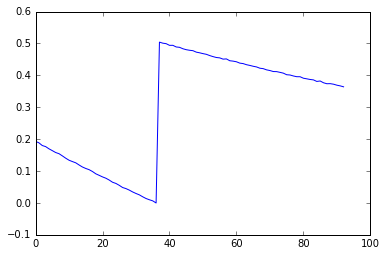

In [9]:
mybragg = -1*np.log10(myspectrum[115:208]/np.max(myspectrum[115:208]))
# mybragg = myspectrum[115:208] # without normalization and without the -log
# mybragg = myspectrum[115:208]
# mybragg = mybragg/np.max(mybragg)+ random.normal(0, 0.001, len(mybragg)) # iniziamo senza rumore aggiunto
mybragg = mybragg+ random.normal(0, 0.001, len(mybragg)) # proviamo senza normalizzazione  

plt.figure
plt.plot(mybragg)

## first step: estimate linear function for the slope before and after the Bragg Edge 

In [10]:
t=np.linspace(0,np.size(mybragg)-1,np.size(mybragg))
t_before= t[0:35]
bragg_before=mybragg[0:35]
t_after= t[45:-1]
bragg_after=mybragg[45:-1]

In [11]:
[slope_before, interception_before] = np.polyfit(t_before, bragg_before, 1)
[slope_after, interception_after] = np.polyfit(t_after, bragg_after, 1)

In [12]:
print(slope_before, interception_before)
print(slope_after, interception_after)

(-0.0053961431543357941, 0.19053202632500013)
(-0.0025000791643378993, 0.59205313273823312)


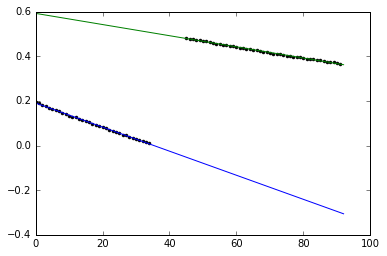

In [13]:
plt.figure
plt.plot(t_before,bragg_before,'.k')
plt.plot(t_after,bragg_after,'.k')

plt.plot(t,interception_before+slope_before*t)
plt.plot(t,interception_after+slope_after*t)


In [14]:
def AdvancedBraggEdgeFittingFirstStep(t,a1,a6):
    return a1 + term0(t,a2_f,a6) + term1(t,a2_f,a5_f,a6) * (term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f))

In [15]:
def AdvancedBraggEdgeFittingSecondStep(t,a2,a5):
    return a1_f + term0(t,a2,a6_f) + term1(t,a2,a5,a6_f) * (term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f))

In [16]:
def AdvancedBraggEdegFittingThirdStep(t,t0,sigma,alpha):
    return a1_f + term0(t,a2_f,a6_f) + term1(t,a2_f,a5_f,a6_f) * (term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma))

In [17]:
def AdvancedBraggEdegFittingFourthStep(t,a1,a2,a5,a6):
    return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (term3(t,t0_f,sigma_f) - term4(t,t0_f,alpha_f,sigma_f)* term5(t,t0_f,alpha_f,sigma_f))

In [18]:
def AdvancedBraggEdegFittingFifthStep(t,t0,sigma,alpha): #this is just the same as the third
    return a1_f + term0(t,a2_f,a6_f) + term1(t,a2_f,a5_f,a6_f) * (term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma))

In [19]:
def AdvancedBraggEdegFittingAll(t,t0,sigma,alpha,a1,a2,a5,a6):
    return a1 + term0(t,a2,a6) + term1(t,a2,a5,a6) * (term3(t,t0,sigma) - term4(t,t0,alpha,sigma)* term5(t,t0,alpha,sigma))

In [20]:
#first guess of paramters
t0_f=30
a2_f=slope_before
a5_f=slope_after
a6_f=t0_f-(2*mybragg[45]/(a5_f-a2_f)) # I assume edge intensity is equal to 1 as I am normalizing
a1_f=interception_before+a2_f*a6_f
sigma_f=-1.0
alpha_f=-1.0


In [21]:
gmodel1 = Model(AdvancedBraggEdgeFittingFirstStep)
gmodel2=Model(AdvancedBraggEdgeFittingSecondStep)
gmodel3=Model(AdvancedBraggEdegFittingThirdStep)
gmodel4=Model(AdvancedBraggEdegFittingFourthStep)
gmodel5=Model(AdvancedBraggEdegFittingFifthStep)
gmodel6=Model(AdvancedBraggEdegFittingAll)

[[Model]]
    Model(AdvancedBraggEdgeFittingFirstStep)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 93
    # variables        = 2
    chi-square         = 2.11592
    reduced chi-square = 0.02325
    Akaike info crit   = -347.82904
    Bayesian info crit = -342.76384
[[Variables]]
    a1:  -0.37182546 +/- 0.055685 (14.98%) (init= 1.819399)
    a6:   202.281623 +/- 11.95312 (5.91%) (init=-301.8575)
[[Correlations]] (unreported correlations are <  0.100)
    C(a1, a6)                    = -0.959



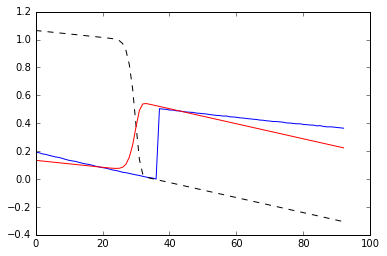

In [22]:
result1 = gmodel1.fit(mybragg, t=t,a1=a1_f, a6=a6_f) 

# AdvancedBraggEdgeFitting(t,t0,alpha,sigma,a1,a2,a5,a6):


print(result1.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result1.init_fit, 'k--')
plt.plot(t, result1.best_fit, 'r-')
plt.show()

[[Model]]
    Model(AdvancedBraggEdgeFittingSecondStep)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 93
    # variables        = 2
    chi-square         = 2.09867
    reduced chi-square = 0.02306
    Akaike info crit   = -348.59069
    Bayesian info crit = -343.52549
[[Variables]]
    a2:  -0.00527952 +/- 0.000135 (2.57%) (init=-0.005396143)
    a5:  -0.00251560 +/- 0.000149 (5.95%) (init=-0.002500079)



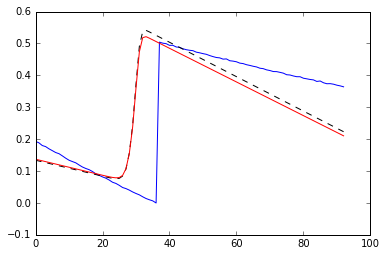

In [23]:
a1_f=result1.best_values.get('a1')
a6_f=result1.best_values.get('a6')

result2=gmodel2.fit(mybragg,t=t, a2=a2_f,a5=a5_f)
print(result2.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result2.init_fit, 'k--')
plt.plot(t, result2.best_fit, 'r-')
plt.show()


[[Model]]
    Model(AdvancedBraggEdegFittingThirdStep)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 93
    # variables        = 3
    chi-square         = 0.46563
    reduced chi-square = 0.00517
    Akaike info crit   = -486.61774
    Bayesian info crit = -479.01994
[[Variables]]
    t0:      36.6366190 +/- 5.07e+05 (1385082.28%) (init= 30)
    sigma:  -0.18026202 +/- 2.48e+05 (137370745.51%) (init=-1)
    alpha:  -0.07828902 +/- 1.36e+05 (173247986.55%) (init=-1)
[[Correlations]] (unreported correlations are <  0.100)
    C(t0, sigma)                 =  1.000
    C(t0, alpha)                 = -1.000
    C(sigma, alpha)              = -1.000



/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


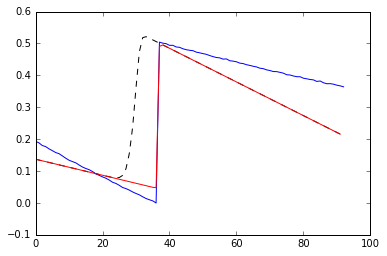

In [24]:
a2_f = result2.best_values.get('a2')
a5_f = result2.best_values.get('a5')

result3 = gmodel3.fit(mybragg,t=t,t0=t0_f,sigma=sigma_f, alpha=alpha_f, nan_policy='propagate')

print(result3.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result3.init_fit, 'k--')
plt.plot(t, result3.best_fit, 'r-')
plt.show()

/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


[[Model]]
    Model(AdvancedBraggEdegFittingFourthStep)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 93
    # variables        = 4
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    a1:  -0.37182546 +/- 0        (0.00%) (init=-0.3718255)
    a2:  -0.00527952 +/- 0        (0.00%) (init=-0.005279528)
    a5:  -0.00251560 +/- 0        (0.00%) (init=-0.002515602)
    a6:   202.281626 +/- 0        (0.00%) (init= 202.2816)



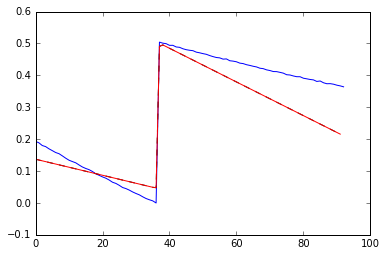

In [25]:
t0_f=result3.best_values.get('t0')
sigma_f=result3.best_values.get('sigma')
alpha_f=result3.best_values.get('alpha')

result4 = gmodel4.fit(mybragg, t=t, a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f,nan_policy='propagate')

print(result4.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result4.init_fit, 'k--')
plt.plot(t, result4.best_fit, 'r-')
plt.show()

/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


[[Model]]
    Model(AdvancedBraggEdegFittingFifthStep)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 93
    # variables        = 3
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    t0:      36.6366190 +/- 0        (0.00%) (init= 36.63662)
    sigma:  -0.18026202 +/- 0        (0.00%) (init=-0.180262)
    alpha:  -0.07828902 +/- 0        (0.00%) (init=-0.07828902)



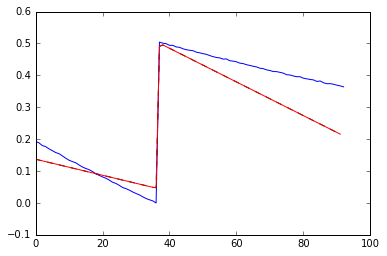

In [26]:
a1_f =result4.best_values.get('a1')
a2_f = result4.best_values.get('a2')
a5_f = result4.best_values.get('a5')
a6_f = result4.best_values.get('a6')

result5=gmodel5.fit(mybragg,t=t, t0=t0_f,sigma=sigma_f, alpha=alpha_f, nan_policy='propagate')

print(result5.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result5.init_fit, 'k--')
plt.plot(t, result5.best_fit, 'r-')
plt.show()

/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/carminati_c/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


[[Model]]
    Model(AdvancedBraggEdegFittingAll)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 93
    # variables        = 7
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    t0:      36.6366190 +/- 0        (0.00%) (init= 36.63662)
    sigma:  -0.18026202 +/- 0        (0.00%) (init=-0.180262)
    alpha:  -0.07828902 +/- 0        (0.00%) (init=-0.07828902)
    a1:     -0.37182546 +/- 0        (0.00%) (init=-0.3718255)
    a2:     -0.00527952 +/- 0        (0.00%) (init=-0.005279528)
    a5:     -0.00251560 +/- 0        (0.00%) (init=-0.002515602)
    a6:      202.281629 +/- 0        (0.00%) (init= 202.2816)



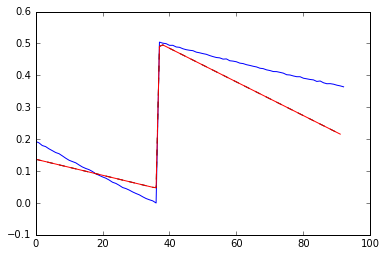

In [27]:
t0_f=result5.best_values.get('t0')
sigma_f=result5.best_values.get('sigma')
alpha_f=result5.best_values.get('alpha')


result6=gmodel6.fit(mybragg,t=t, t0=t0_f,sigma=sigma_f, alpha=alpha_f, a1=a1_f, a2=a2_f, a5=a5_f, a6=a6_f, nan_policy='propagate')

print(result6.fit_report())
plt.figure
plt.plot(t, mybragg, 'b-')
plt.plot(t, result6.init_fit, 'k--')
plt.plot(t, result6.best_fit, 'r-')
plt.show()
